<a href="https://colab.research.google.com/github/calumrussell/fpl/blob/master/FPL_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this post, we are going to calculate the rolling fixture difficulty for all teams in the Premier League.

We are going to use the team strength ratings from [vaastav's Github repo](https://github.com/vaastav/Fantasy-Premier-League/tree/master/data/2019-20). In reality, we would probably gain accuracy from adding both strength/defence and home/away parameters to our strength model. 

Irregardless, the code involved in constructing rolling fixture difficulty would be similar.

In [1]:
import pandas as pd
import numpy as np

##Import fixtures from Github
fixtures = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/fixtures.csv")
##At time of writing, some fixtures are yet to be scheduled so there
##are a few rows that need to be dropped, these will presumably
##disappear later
fixtures.dropna(subset=['kickoff_time'], inplace=True)

In [2]:
from datetime import datetime

##Create new column with epoch time, this is not strictly necessary but
##I prefer working with epoch dates, and I like to make sure that
##the sorting is correct
date_str = "%Y-%m-%dT%H:%M:%SZ"
fixtures['epoch'] = fixtures['kickoff_time'].apply(lambda x: datetime.strptime(x, date_str).timestamp())

In [3]:
##Import teams from Github
teams = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/teams.csv")

In [4]:
##We have to merge our team strengths onto our fixtures, this
##requires lots of confusing looking merges but is actually
##straightforward
team_strength=teams[['id', 'strength']]
with_away_strength = fixtures.merge(team_strength, left_on='team_a', right_on='id')
with_away_strength.rename(columns={"strength": "away_strength"}, inplace=True)
with_home_strength = with_away_strength.merge(team_strength, left_on='team_h', right_on='id')
with_home_strength.rename(columns={"strength": "home_strength"}, inplace=True)
with_home_away_strength = with_home_strength

In [5]:
league_teams = with_home_away_strength['team_a'].unique()

In [6]:
##We have our data formatted, we now need to work out how to calculate
##fixture strength for each team, over each rolling period

##There are quite a few ways to do this. It is possible to calculate rolling
##fixture difficulty using a pandas one-liner - groupby and rolling - but
##we would need rows which are unique to each team, instead we have match rows
##with home and away sides in one row. This can be solved by merging our dataframe
##onto itself...but this is a bit confusing.

##Instead we are just going to loop through each team, filter our dataframe for
##matches in which that team is a partcipant, calculate the difficulty of
##opponents, and then call pandas' rolling function on that list of numbers.
##I think this approach is going to be slower in some cases but it won't matter
##here and we can highlight some techniques for working with pandas dataframes.

res = []
for team in league_teams:
    team_matches = with_home_away_strength[
        (with_home_away_strength['team_a']==team) |
        (with_home_away_strength['team_h']==team)
    ]
    team_matches.sort_values('epoch', inplace=True)
    team_matches['opp_strength'] = np.where(
        team_matches['team_a'] == team,
        team_matches['home_strength'],
        team_matches['away_strength']
    )
    team_matches.to_csv('test.csv')
    team_matches['rolling'] = team_matches['opp_strength'].rolling(5).mean()
    team_matches['team_id'] = team
    team_matches['gw'] = team_matches['event'] - 4
    temp = team_matches[['team_id', 'epoch','rolling', 'gw']]
    temp.dropna(subset=['rolling'], inplace=True)
    res.append(temp)
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [7]:
rolling_fixture_difficulty = pd.concat(res)

In [8]:
##Again, note that some teams, at the time of writing, have not been assigned
##their full season of matches.
rolling_fixture_difficulty.groupby('team_id').describe()['rolling']

,count,mean,std,min,25%,50%,75%,max
team_id,,,,,,,,
1,34.0,3.194118,0.398437,2.6,2.85,3.2,3.40,4.2
2,33.0,3.181818,0.297337,2.6,3.00,3.2,3.40,3.8
3,34.0,3.200000,0.214617,2.8,3.00,3.2,3.40,3.6
4,33.0,3.175758,0.277298,2.4,3.00,3.2,3.40,3.8
5,34.0,3.158824,0.240098,2.4,3.00,3.2,3.40,3.6
6,34.0,3.158824,0.456015,2.4,2.80,3.2,3.60,3.8
7,34.0,3.188235,0.299256,2.8,3.00,3.2,3.40,4.0
8,34.0,3.282353,0.365539,2.6,3.00,3.4,3.60,4.0
9,34.0,3.123529,0.241283,2.6,3.00,3.2,3.20,3.6


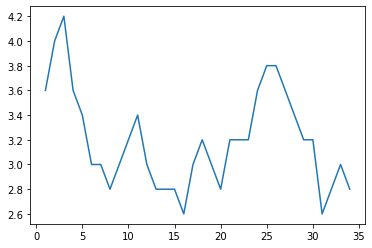

In [9]:
import matplotlib.pyplot as plt

plt.plot(
    rolling_fixture_difficulty[rolling_fixture_difficulty['team_id'] == 1]['gw'],
    rolling_fixture_difficulty[rolling_fixture_difficulty['team_id'] == 1]['rolling']
)
plt.show()

A useful extension of this anaysis would be to calculate the meaning of changes in fixture difficulty in terms of points. For example: how many more points does a team that is rated 3 concede relative to a team that is rated 4?